In [1]:
from srm_helper import *
import pandas as pd
import random as rd
import numpy as np
from sklearn.model_selection import KFold 
from sklearn.metrics import r2_score
import matplotlib
import scipy.stats as stats

matplotlib.rcParams['figure.dpi'] = 500
import scipy.optimize as opt



In [2]:
tol = .5  # MS2 fragment tolerance for QqQ optimized transitions
ppmTol = 10  # m/z tolerance for HRMS data in ppm
numCores = 2  # number of CPU cores to use
num2Train = 10 #number of compounds to learn equation
numIters = 1000 #number of iterations

In [3]:
### format csv files from whole transition list
totalTransitionInfoFn = "../data/IDX/6460_m3t_transitions.csv"

totalTransitions = pd.read_csv(totalTransitionInfoFn)

switcher = {"Positive":1,"Negative":-1}



In [4]:

allCpds = list(set(totalTransitions["Name"].values))
numCpds = len(allCpds)

In [5]:
if __name__ == '__main__':
    
    targets = totalTransitions
    cpds = []
    toDrop = []
    for index,row in targets.iterrows():
        if (row['Name'],row["Charge"]) in cpds:
            toDrop.append(index)
        else:
            cpds.append((row['Name'],row["Charge"]))

    targets = targets.drop(toDrop)
    goodCols = ["Name","rt_start","rt_end","mz","Charge"]
    targets = targets[goodCols]
    targets.to_csv("tmp_targets_for_evaluation.csv",index=False)

    # create srm_maker object
    srm_maker = SRM_maker(ppm=ppmTol, numCores=numCores)

    msFilenames = ["../data/IDX/IDX_MS2_data/M3T_10uM_pos_DDA_10NCEs_25-35_50ms_5e4_DE5s_updatedRT.mzML",
                   "../data/IDX/IDX_MS2_data/M3T_10uM_neg_DDA_10NCEs_25-35_50ms_5e4_DE5s_updatedRT.mzML",
                   "../data/IDX/IDX_MS2_data/M3T_10uM_pos_DDA_10NCEs_25-35_80ms_1e4_DE5s_updatedRT_missing.mzML"]


    # set datafiles to build srms
    targets = pd.read_csv("tmp_targets_for_evaluation.csv")

    srm_table = pd.DataFrame()
    breakdownCurves = {}

    for msFilename in msFilenames:

        # create SRM table
        srm_table1, _ = srm_maker.createSRMsCE(msFilename, targets)

        srm_table = pd.concat((srm_table,srm_table1),axis=0,ignore_index=True)

        

Library loaded successfully: 0 spectra found
reading data...
2950  MS2 spectra detected
Number of compounds with acquired MS2:  46
Number of spectra to deconvolve:  2711
read data
starting to find transitions
writing results
reading data...
2566  MS2 spectra detected
Number of compounds with acquired MS2:  48
Number of spectra to deconvolve:  2092
read data
starting to find transitions
writing results
reading data...
779  MS2 spectra detected
Number of compounds with acquired MS2:  9
Number of spectra to deconvolve:  574
read data
starting to find transitions
writing results


In [6]:
transition_indices = {}
for index,row in totalTransitions.iterrows():
    new = True
    for x in transition_indices:
        if x[0] == row["Name"] and np.abs(row["Product mz"] - x[1]) < tol and row["Charge"] == x[2]:
            new = False
            transition_indices[x]["QqQ Optimized CE"] = row["CE"]
            break
    if new:
        transition_indices[(row["Name"],row["Product mz"],row["Charge"])] = {"QqQ Optimized CE":row["CE"]}
        
for index,row in srm_table.iterrows():
    new = True
    for x in transition_indices:
        if x[0] == row["Name"] and np.abs(row["Product mz"] - x[1]) < tol and row["Charge"] == x[2]:
            new = False
            transition_indices[x]["HRMS Optimized CE (converted)"] = (row["mz"], row["CE"])
            break
    if new:
        transition_indices[(row["Name"],row["Product mz"],row["Charge"])] = {"HRMS Optimized CE (converted)": (row["mz"], row["CE"])}
evaluation_results = pd.DataFrame.from_dict(transition_indices,orient="index")
evaluation_results



QqQ Optimized CE HRMS Optimized CE (converted)
cAMP       136.10 1              24.0           (330.0597957, 40.0)
           97.10  1              20.0                           NaN
           312.00 1              16.0                           NaN
           119.10 1              40.0           (330.0597957, 80.0)
cGMP       152.00 1              20.0            (346.054706, 25.0)
...                               ...                           ...
Glycine    61.42  1               NaN     (76.03930600000002, 40.0)
Serotonine 78.99  1               NaN            (177.102239, 50.0)
Uracil     95.06  1               NaN            (113.034556, 20.0)
           84.08  1               NaN            (113.034556, 50.0)
           55.02  1               NaN            (113.034556, 35.0)

[536 rows x 2 columns]

In [7]:
if __name__ == "__main__":
    filt = totalTransitions
    filt.to_csv("tmp_to_learn_conv.csv",index=False)


    # create srm_maker object
    srm_maker = SRM_maker(ppm=ppmTol, numCores=numCores)

    # set datafiles for learning conversion
    trainingData = pd.read_csv("tmp_to_learn_conv.csv")

    msFilenames = ["../data/IDX/IDX_MS2_data/M3T_10uM_pos_DDA_10NCEs_25-35_50ms_5e4_DE5s_updatedRT.mzML",
                   "../data/IDX/IDX_MS2_data/M3T_10uM_neg_DDA_10NCEs_25-35_50ms_5e4_DE5s_updatedRT.mzML",
                   "../data/IDX/IDX_MS2_data/M3T_10uM_pos_DDA_10NCEs_25-35_80ms_1e4_DE5s_updatedRT_missing.mzML"]

    #build conversion
    merged = srm_maker.buildConversion(msFilenames, trainingData, tic_cutoff=0, frag_cutoff=0,
                                       frag_ppm_tolerance=2 * 1e6 * .5 / 200)
    
    merged.to_csv("../data/IDX/all_cpds_merged_to_learn_conversion_6460.csv")
    
    print(srm_maker.getConversionEquationString())

Library loaded successfully: 0 spectra found
reading data...
2950  MS2 spectra detected
Number of compounds with acquired MS2:  46
Number of spectra to deconvolve:  2711
read data
reading data...
2566  MS2 spectra detected
Number of compounds with acquired MS2:  48
Number of spectra to deconvolve:  2092
read data
reading data...
779  MS2 spectra detected
Number of compounds with acquired MS2:  9
Number of spectra to deconvolve:  574
read data
Finding target transitions
gathering optimal CEs
built conversion
CE = 0.02270671174200067*mz + 0.47288592710406047*ce + -3.0269227139678905


In [8]:
merged

,Name,mz,rt_start,rt_end,Product mz,Charge,CE,Training,HRMS_CE,Converted_CE
0,cAMP,330.059796,1.78,3.57,136.1,1,24,1,40.0,23.383087
1,cAMP,330.059796,1.78,3.57,97.1,1,20,1,30.0,18.654228
2,cAMP,330.059796,1.78,3.57,312.0,1,16,1,25.0,16.289798
3,cAMP,330.059796,1.78,3.57,119.1,1,40,1,80.0,42.298524
4,cGMP,346.054706,5.17,5.58,152.0,1,20,0,30.0,19.017420
...,...,...,...,...,...,...,...,...,...,...
289,Lysine,147.112806,11.13,12.00,56.2,1,36,0,60.0,28.686681
290,Lysine,147.112806,11.13,12.00,67.2,1,28,0,50.0,23.957822
291,Cysteine,122.027026,6.99,7.43,59.2,1,24,0,40.0,18.659347
292,Cysteine,122.027026,6.99,7.43,76.2,1,12,0,25.0,11.566058


In [9]:
if __name__ == "__main__":
    #get random training compounds 
    r2s = {}
    mzRange = {}
    nceRange = {}
    numEval = 20
    numIters = 1000
    #testCpds = rd.sample(allCpds,k=numEval)
    #trainCpds = [x for x in allCpds if x not in testCpds]

    for num2Train in range(2,40):
        
        r2s[num2Train] = []
        mzRange[num2Train] = []
        nceRange[num2Train] = []
        print(num2Train)

        trainingCpds = []
        for _ in range(numIters):
            tmp = rd.sample(allCpds,k=num2Train)
            trainingCpds.append(tmp)

        for cpds in trainingCpds:
            goodInds = []
            for index,row in merged.iterrows():
                if row["Name"] in cpds:
                    goodInds.append(index)
                    
            testCpds = rd.sample([x for x in allCpds if x not in cpds],k=numEval)

            
            tmp = merged.loc[goodInds,:]
            X = np.array([tmp["mz"].values,tmp["HRMS_CE"],[1 for _ in range(len(tmp))]]).transpose()
            y = tmp["CE"].values
            
            if len(X) > 1:
            
                mzRange[num2Train].append(max(X[:,0])-min(X[:,0]))
                nceRange[num2Train].append(max(X[:,1])-min(X[:,1]))

                #find equation
                linreg = LinearRegression(fit_intercept=False)
                linreg.fit(X,y)
                converter = lambda x: linreg.predict([[x[0],x[1],1]])[0]

                predCEs = []
                trueCEs = []

                for index,row in evaluation_results.iterrows():
                    if index[0] in testCpds:
                        if not pd.isna(row["QqQ Optimized CE"]) and type(row["HRMS Optimized CE (converted)"]) == type(tuple()):
                            trueCEs.append(row["QqQ Optimized CE"])
                            predCEs.append(converter(row["HRMS Optimized CE (converted)"]))


                r2 = r2_score(trueCEs,predCEs)
                r2s[num2Train].append(r2)
            

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


1000


Text(0, 0.5, 'frequency')

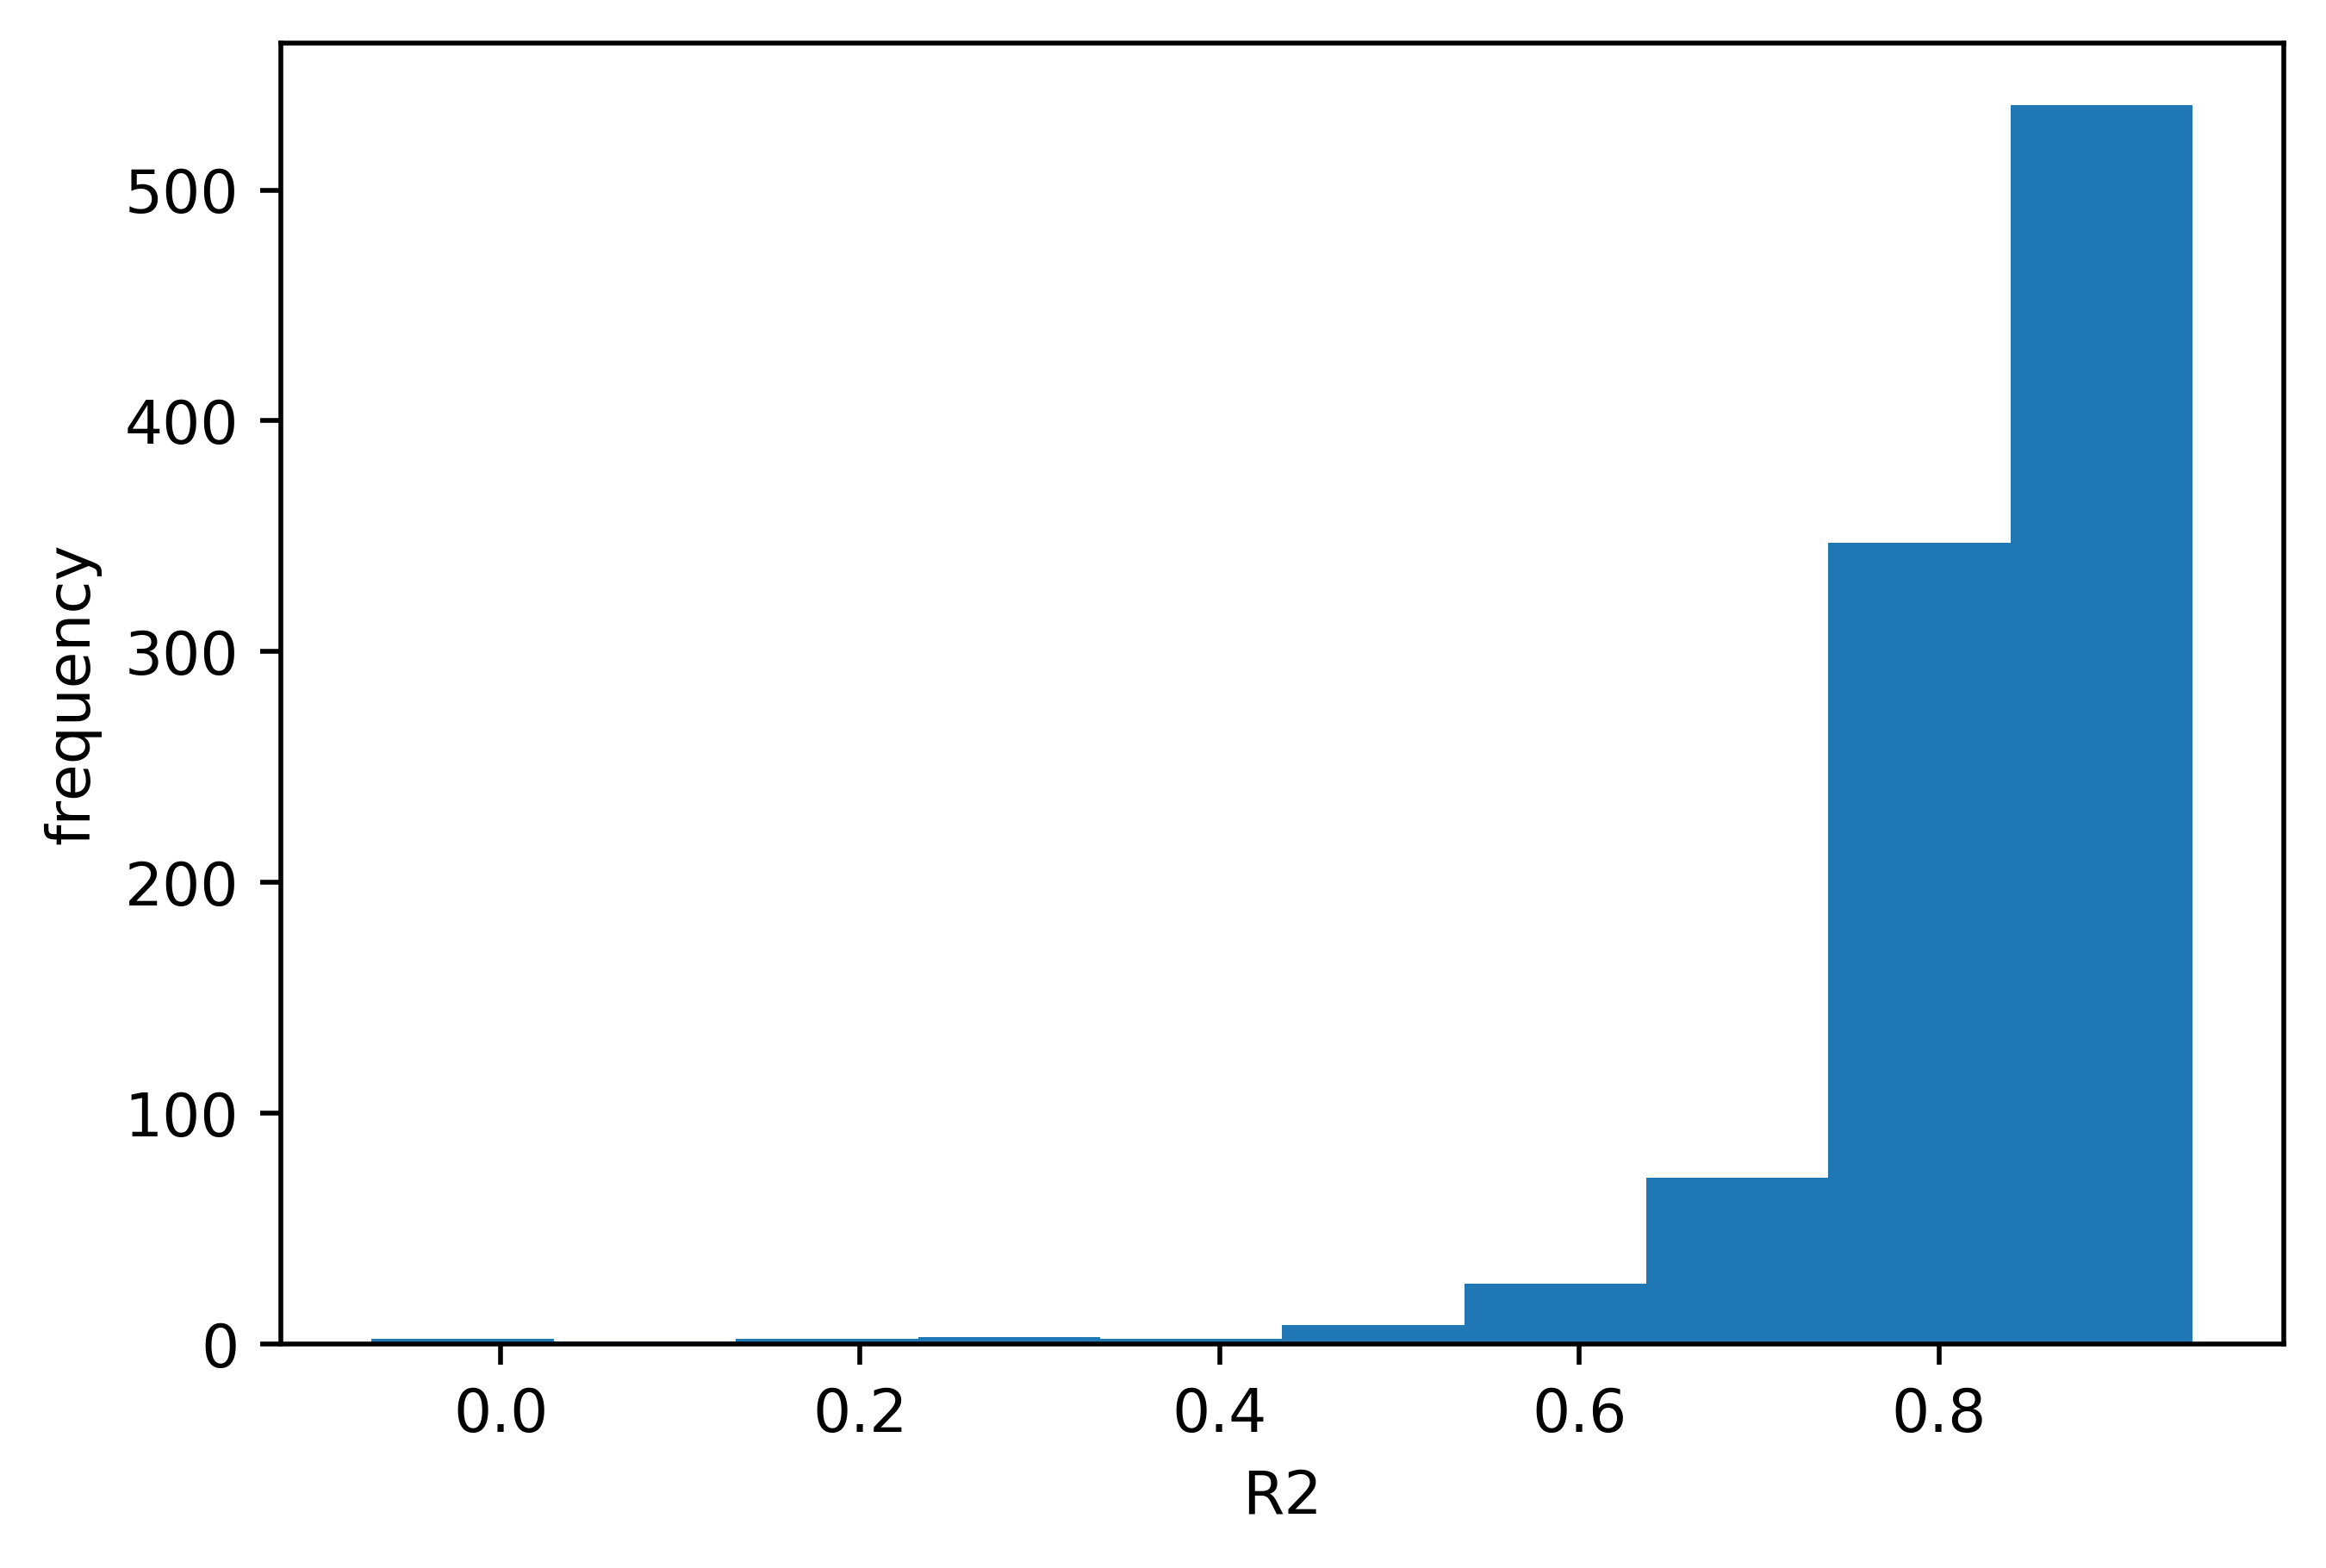

In [10]:
plt.hist([x for x in r2s[10] if x > -.2])
print(len([x for x in r2s[10] if x > -.2]))
plt.xlabel("R2")
plt.ylabel("frequency")
#plt.savefig("r2_hist_at_10cpds.png")


SpearmanrResult(correlation=0.27974545883951474, pvalue=1.953086451454573e-19)


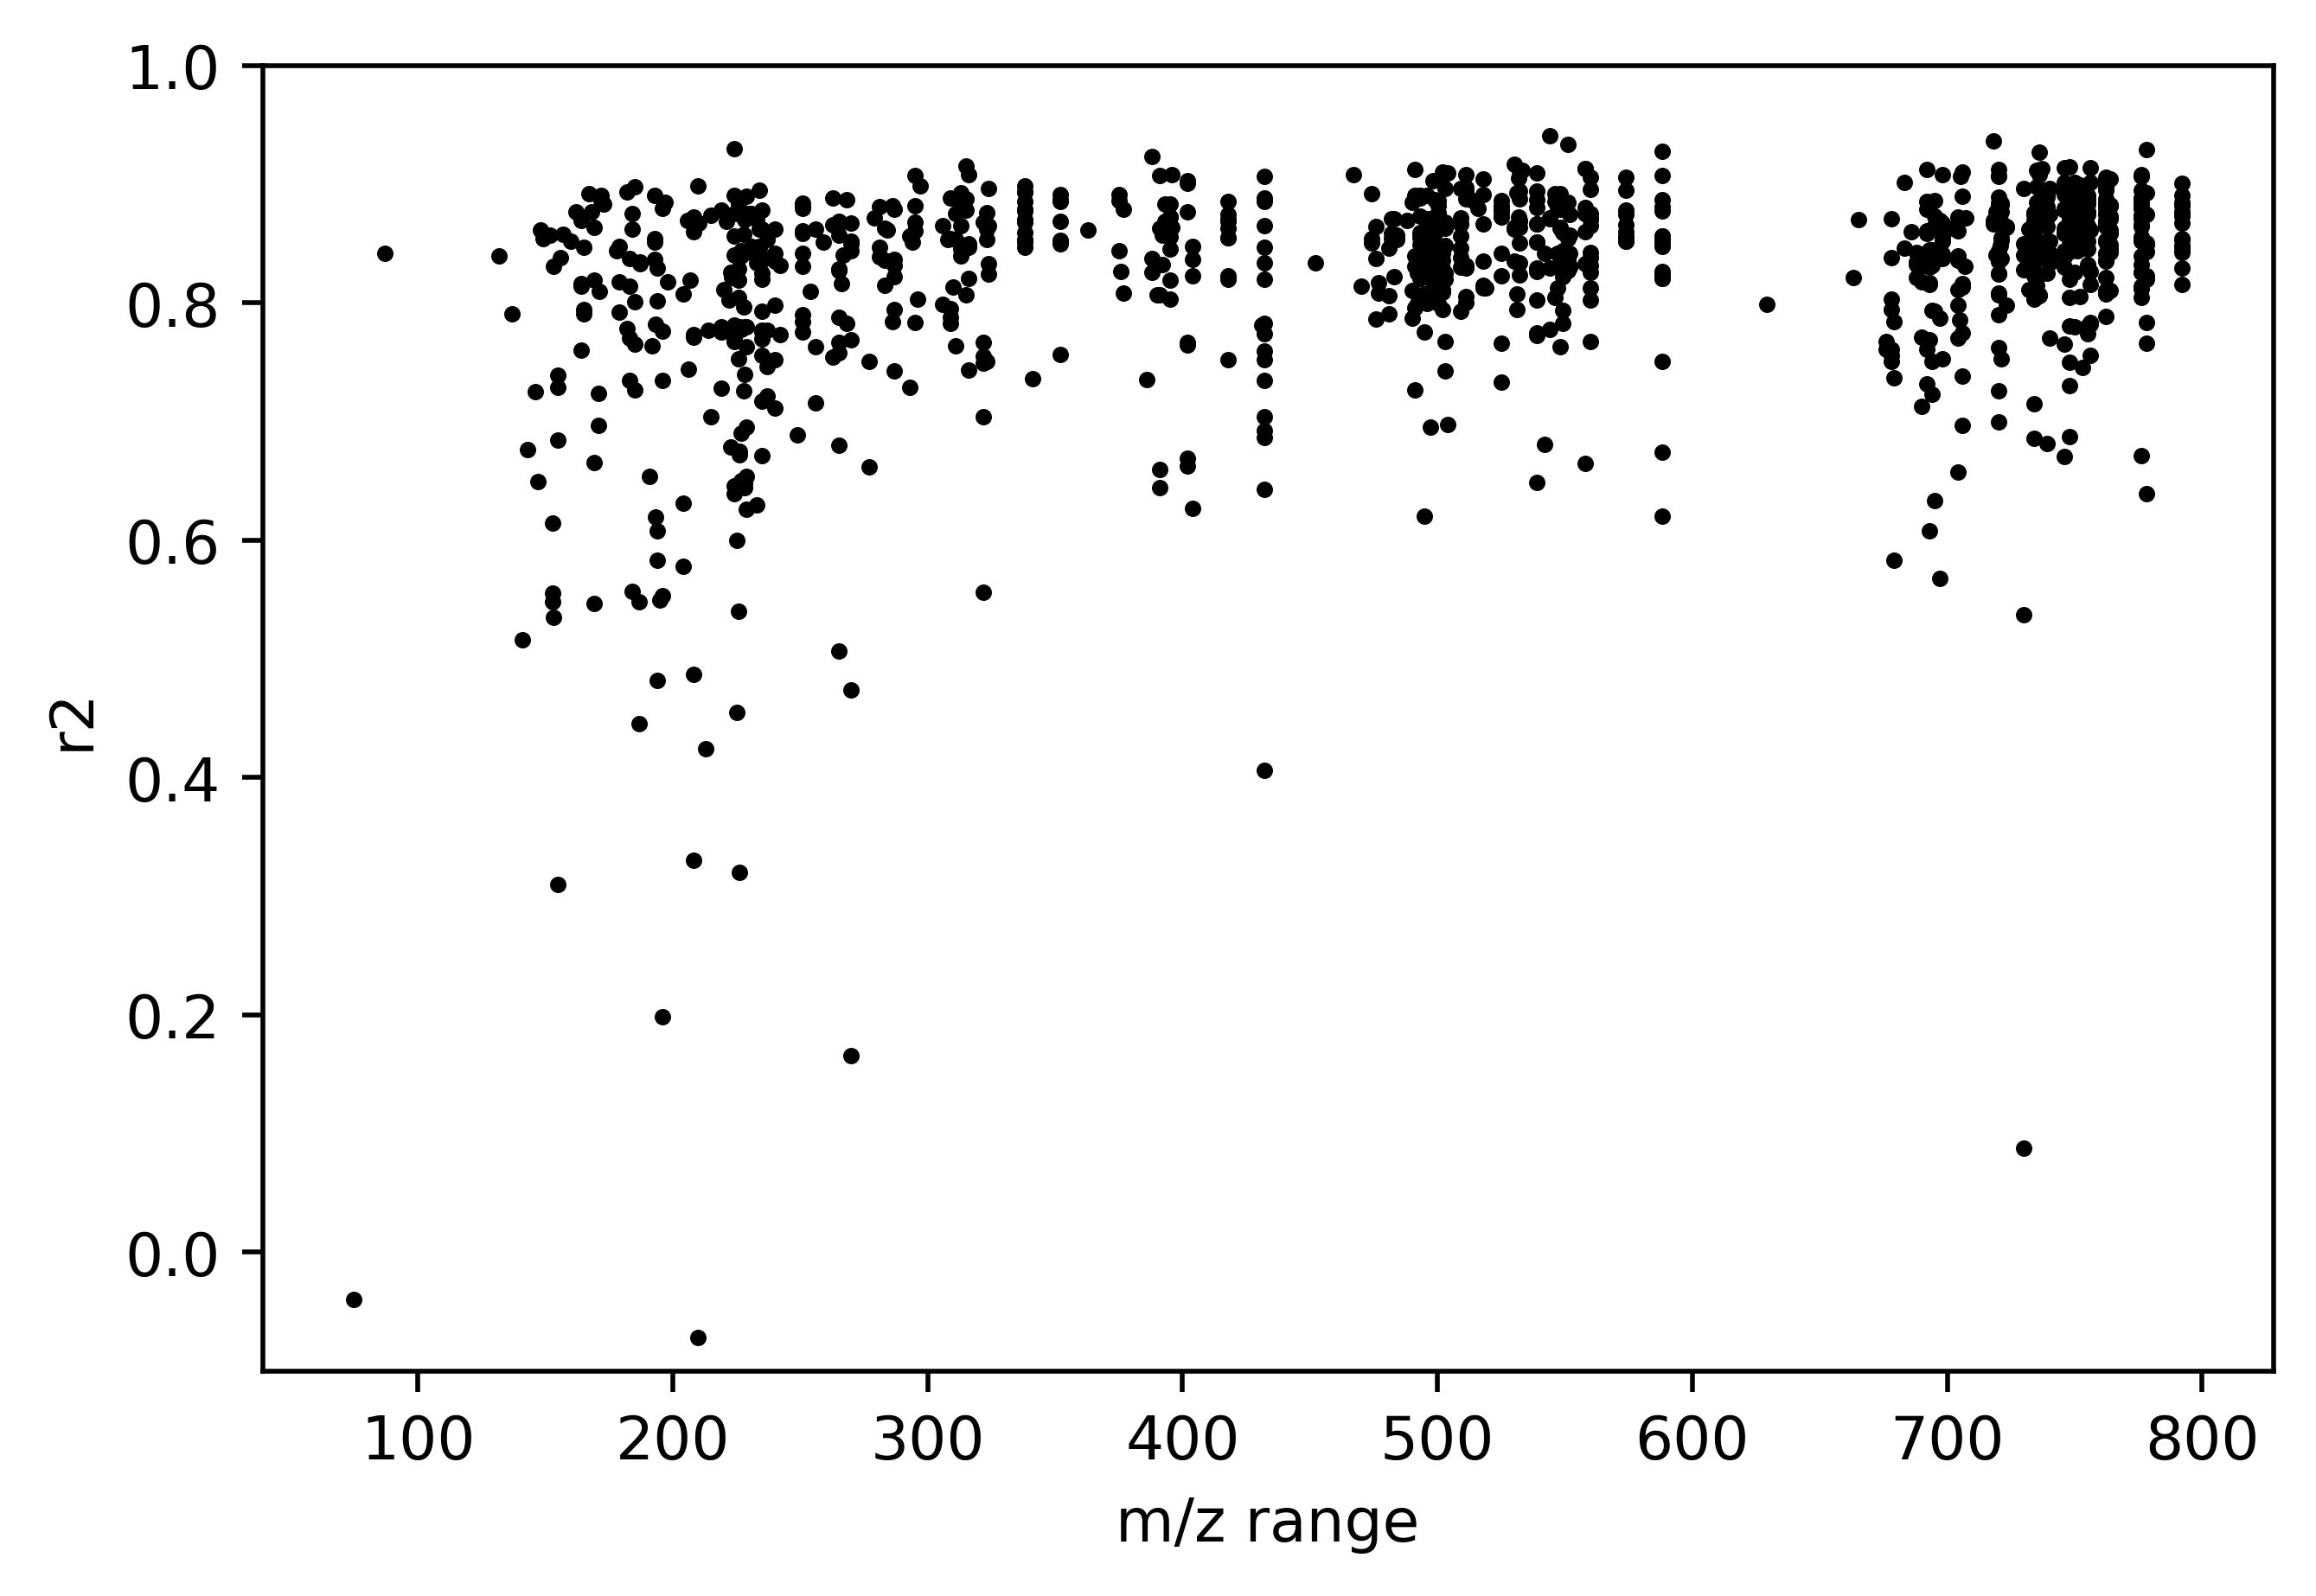

In [11]:
numCpd = 10
plt.scatter(mzRange[numCpd],r2s[numCpd],color="black",s=3)
plt.xlabel("m/z range")
plt.ylabel("r2")
plt.ylim((-.1,1))

print(stats.spearmanr(mzRange[numCpd],r2s[numCpd]))
#plt.savefig("mzRange_r2_"+str(numCpd)+"cpd.png")

SpearmanrResult(correlation=0.022906254626091742, pvalue=0.46934306927733804)


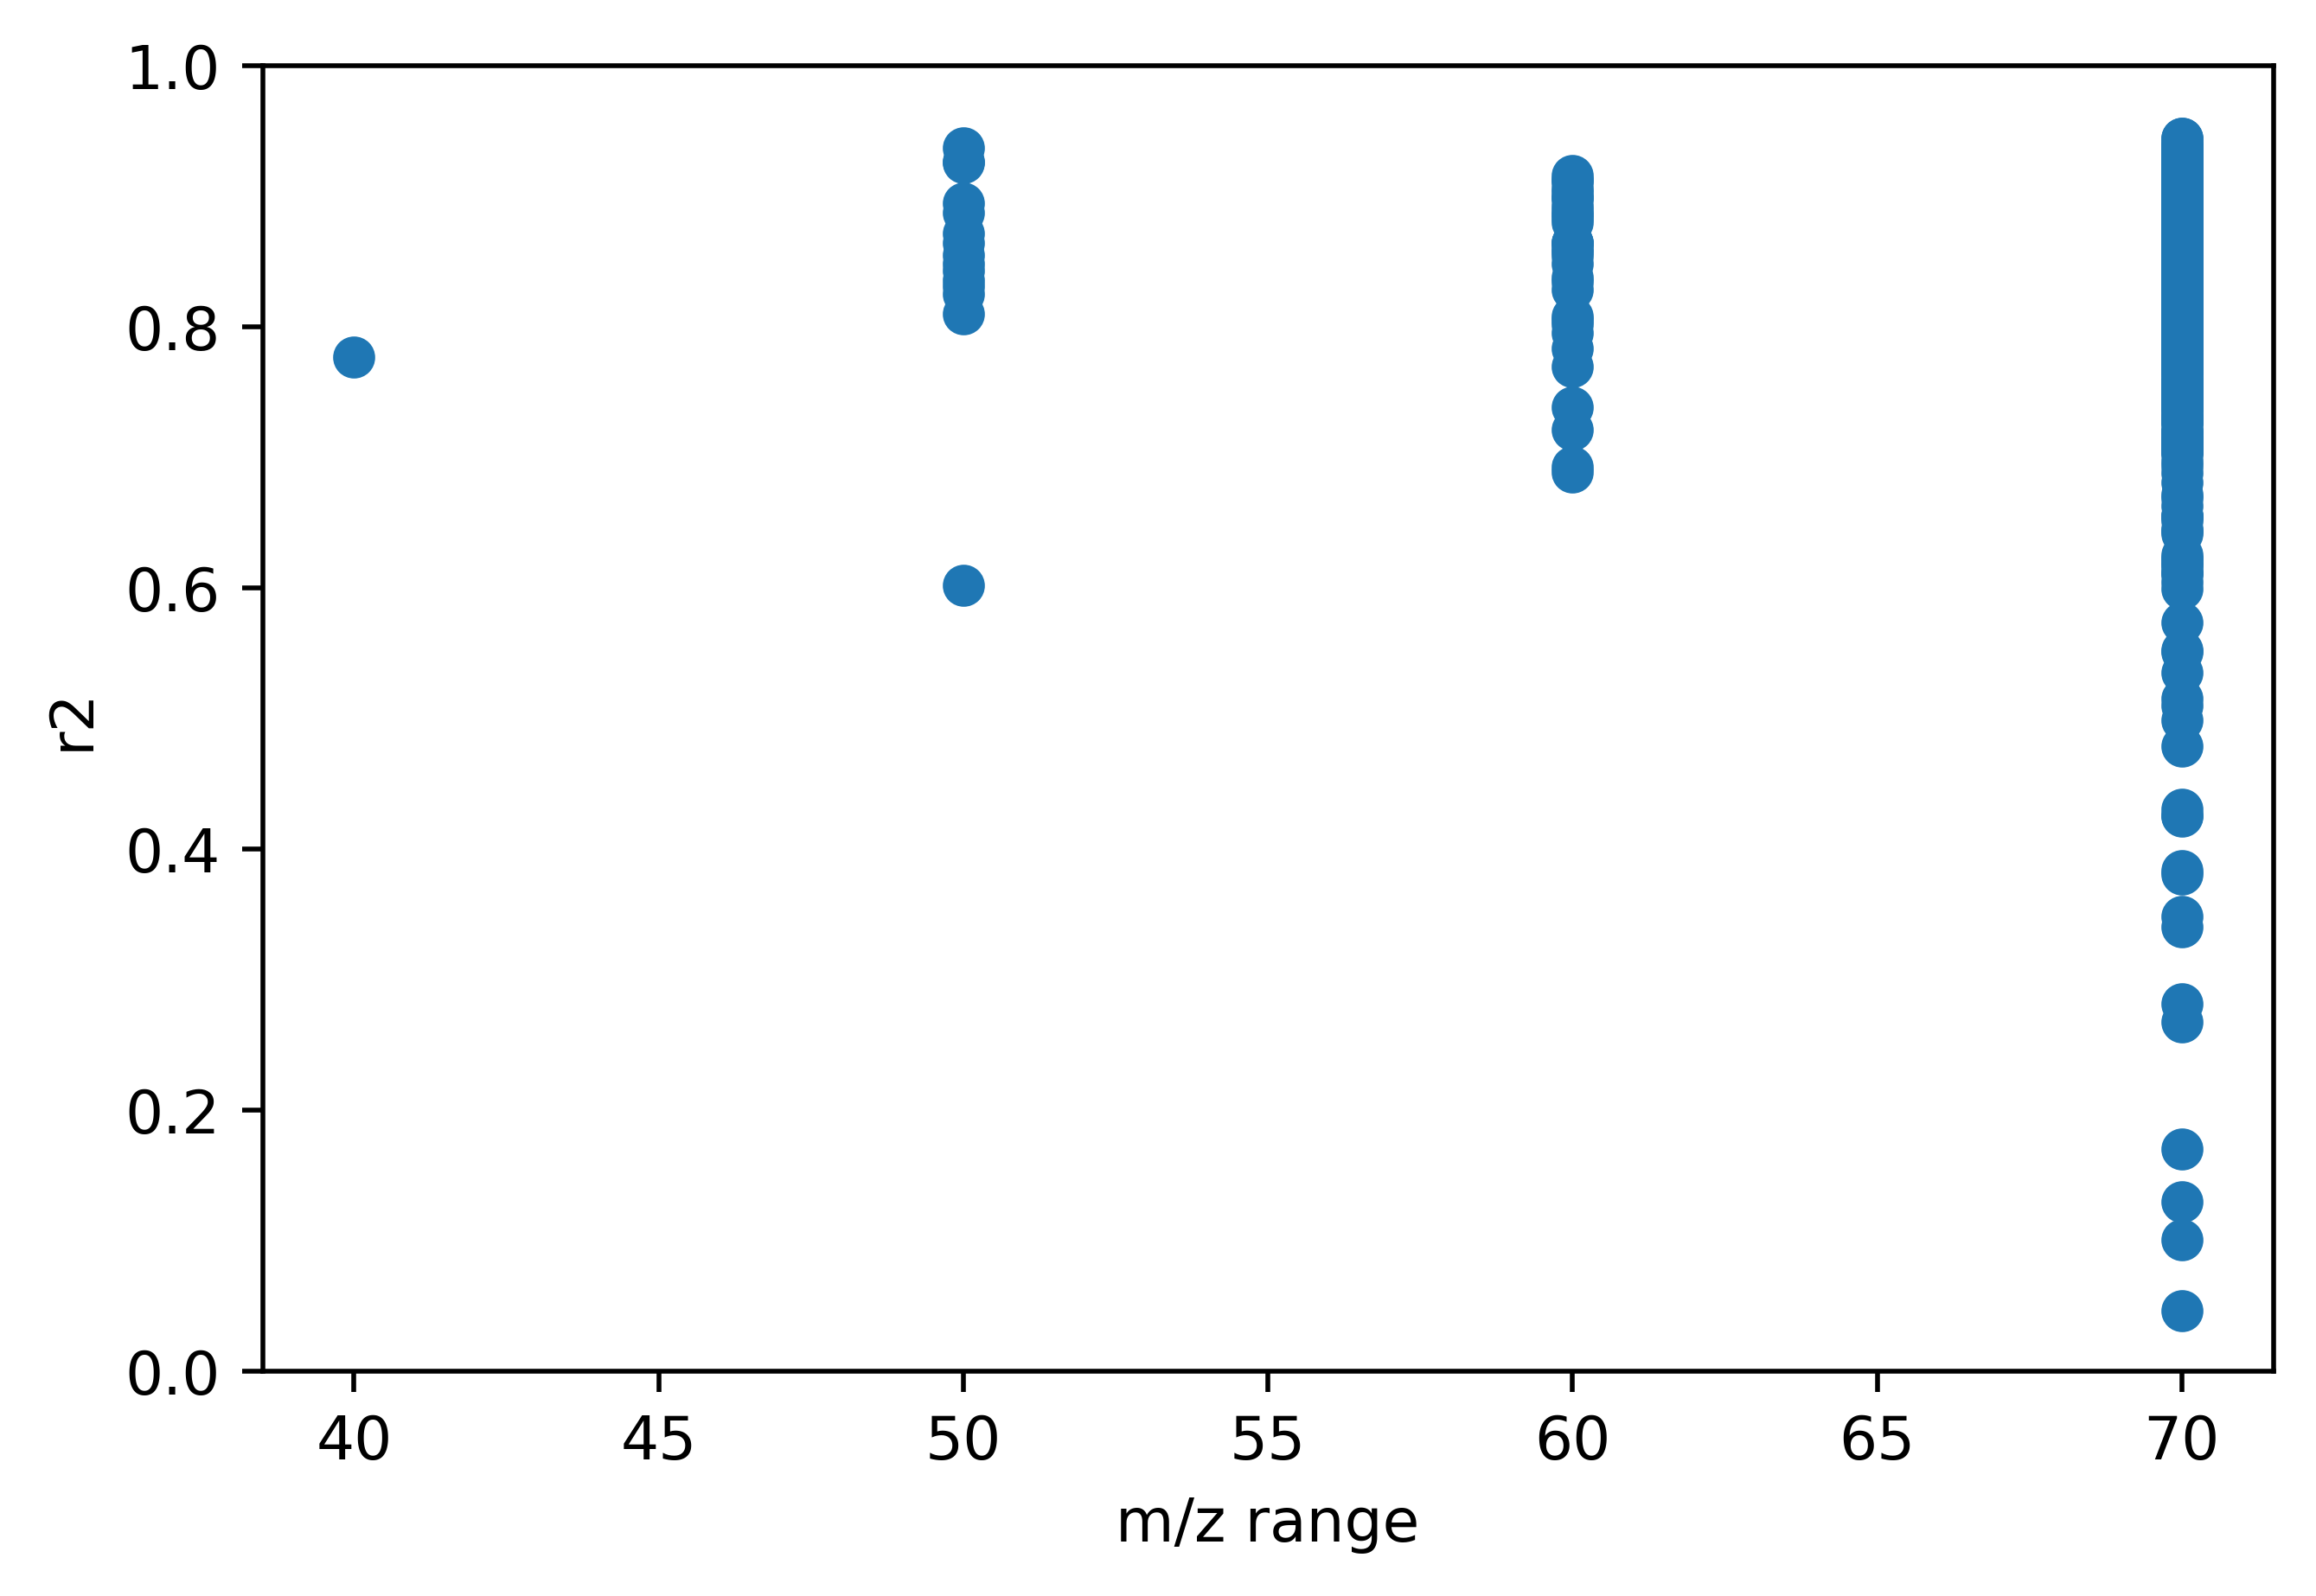

In [78]:
numCpd = 10
plt.scatter(nceRange[numCpd],r2s[numCpd])
plt.xlabel("m/z range")
plt.ylabel("r2")
plt.ylim((0,1))

print(stats.spearmanr(nceRange[numCpd],r2s[numCpd]))

In [71]:
print(r2s.keys())

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])


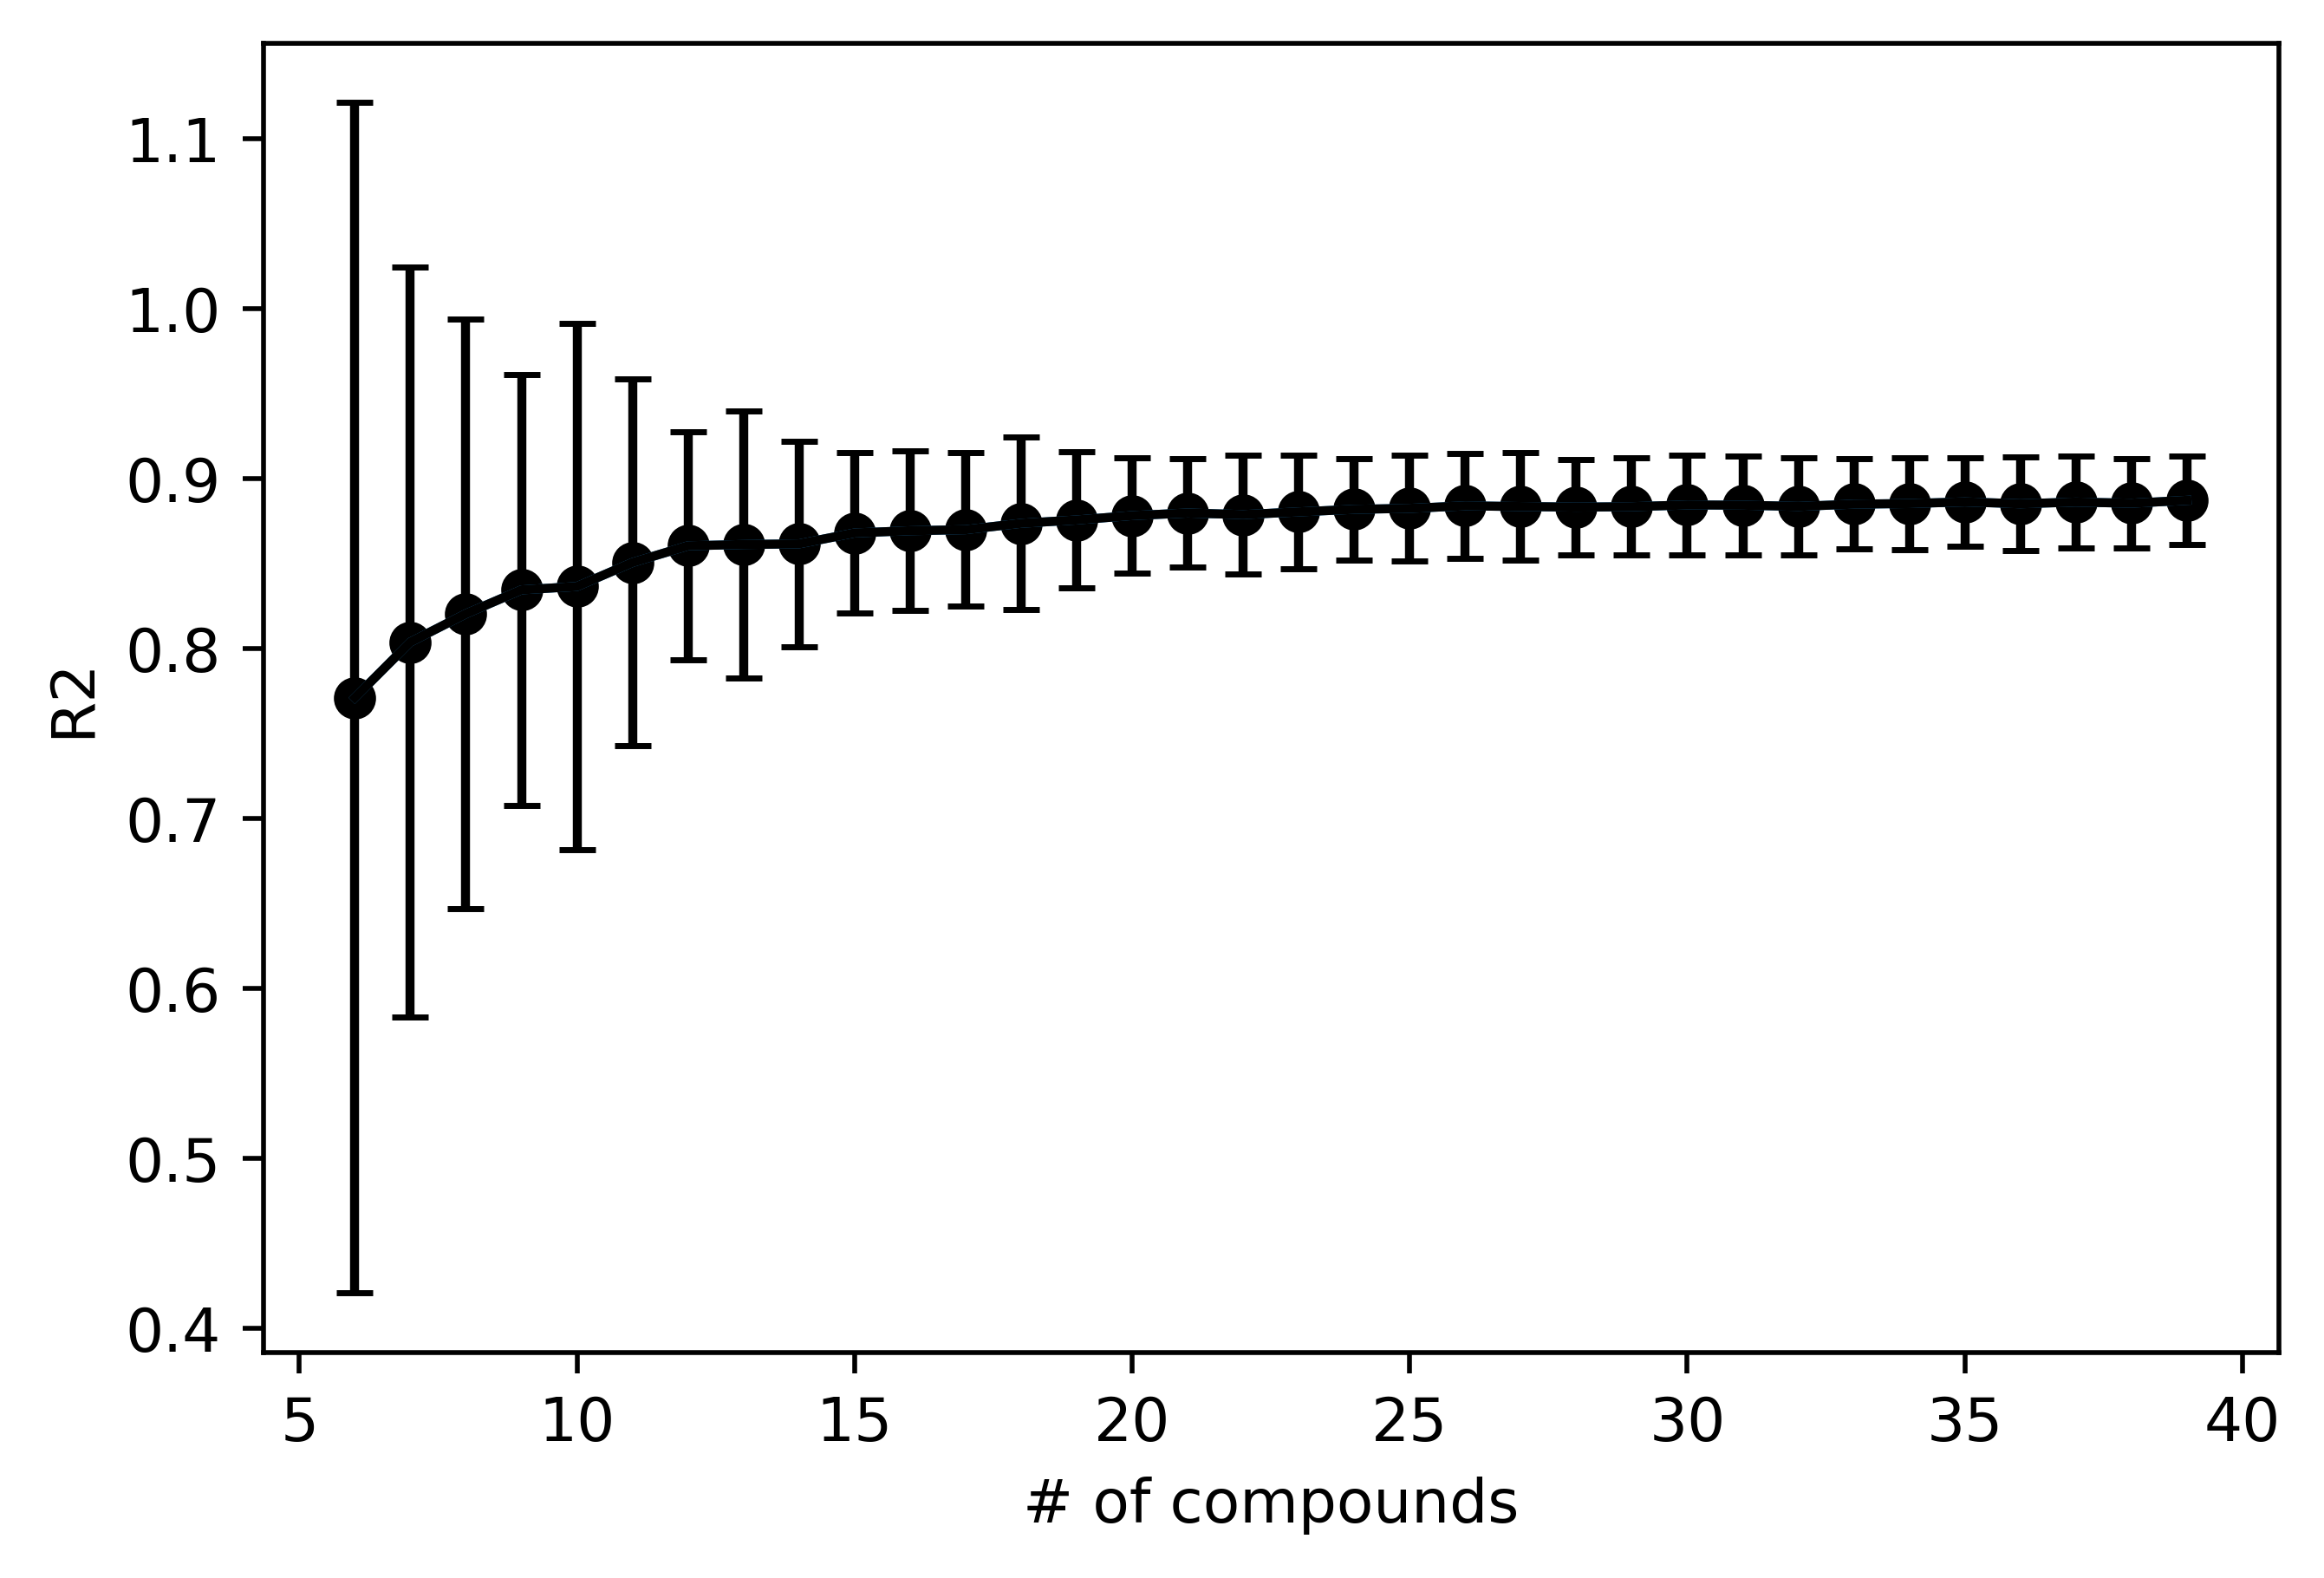

In [72]:
keys = list(r2s.keys())
keys.sort()
keys = keys[4:]
vals = [np.mean(r2s[k]) for k in keys]
errs = [np.std(r2s[k]) for k in keys]
plt.scatter(keys,vals,color="black")
plt.errorbar(keys,vals,yerr=errs,color="black",capsize=3)
plt.plot(keys,vals)
#plt.ylim((0,1.2))
plt.xlabel("# of compounds")
plt.ylabel("R2")
#r2 = r2_score(merged["CE"],merged["HRMS_CE"])
#plt.plot(keys,[r2 for _ in keys],color="red",label="no conversion")
plt.savefig("num_cpds_plot.png")